<a href="https://colab.research.google.com/github/Bhandari007/Timeseries-and-sequence-models/blob/main/C4W2_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 2: Predicting time series

In this notebook, we will be using a deep neural network to create forecasts

In [24]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass

# Generating the data

In [25]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi), 
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

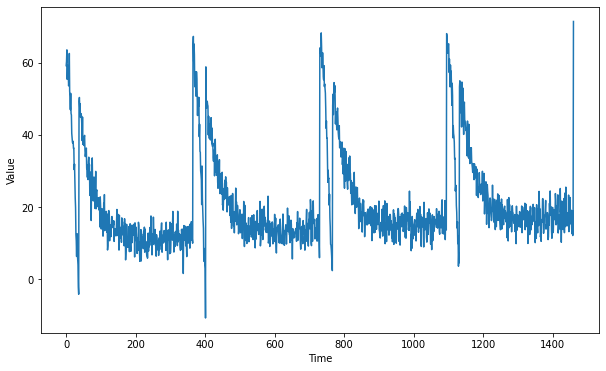

In [26]:
def generate_time_series():
    # The time dimension or the x-coordinate of the time series
    time = np.arange(4 * 365 + 1, dtype="float32")

    # Initial series is just a straight line with a y-intercept
    y_intercept = 10
    slope = 0.005
    series = trend(time, slope) + y_intercept

    # Adding seasonality
    amplitude = 50
    series += seasonality(time, period=365, amplitude=amplitude)

    # Adding some noise
    noise_level = 3
    series += noise(time, noise_level, seed=51)
    
    return time, series


@dataclass
class G:
  TIME, SERIES = generate_time_series()
  SPLIT_TIME = 1100
  WINDOW_SIZE = 20
  BATCH_SIZE = 32
  SHUFFLE_BUFFER_SIZE = 1000

# Plot the generated series
plt.figure(figsize = (10,6))
plot_series(G.TIME, G.SERIES)
plt.show()

# Splitting the data

In [27]:
def train_val_split(time, series, time_step = G.SPLIT_TIME):
  time_train = time[:time_step]
  series_train = series[:time_step]
  time_valid = time[time_step:]
  series_valid = series[time_step:]

  return time_train, series_train, time_valid, series_valid

# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)


In [28]:
def windowed_dataset(series, window_size = G.WINDOW_SIZE, batch_size = G.BATCH_SIZE, shuffle_buffer = G.SHUFFLE_BUFFER_SIZE):

  # Create dataset from the series
  dataset = tf.data.Dataset.from_tensor_slices(series)

  # Slice the dataset into the appropriate windows
  dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)

  # Flatten the dataset
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))

  # Shuffle it
  dataset = dataset.shuffle(shuffle_buffer)

  # Split it into the features and labels
  dataset = dataset.map(lambda window: (window[:-1], window[-1]))

  # Batch it
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset


In [29]:
# Test your function with windows size of 1 and no shuffling
test_dataset = windowed_dataset(series_train, window_size=1, batch_size=5, shuffle_buffer=1)

# Get the first batch of the test dataset
batch_of_features, batch_of_labels = next((iter(test_dataset)))

print(f"batch_of_features has type: {type(batch_of_features)}\n")
print(f"batch_of_labels has type: {type(batch_of_labels)}\n")
print(f"batch_of_features has shape: {batch_of_features.shape}\n")
print(f"batch_of_labels has shape: {batch_of_labels.shape}\n")
print(f"batch_of_features is equal to first five elements in the series: {np.allclose(batch_of_features.numpy().flatten(), series_train[:5])}\n")
print(f"batch_of_labels is equal to first five labels: {np.allclose(batch_of_labels.numpy(), series_train[1:6])}")

batch_of_features has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_labels has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_features has shape: (5, 1)

batch_of_labels has shape: (5,)

batch_of_features is equal to first five elements in the series: True

batch_of_labels is equal to first five labels: True


# Defining the model architecture

In [30]:
def create_model(window_size = G.WINDOW_SIZE):
  model = tf.keras.models.Sequential([
      tf.keras.layers.Dense(10, input_shape = [window_size], activation = 'relu'),
      tf.keras.layers.Dense(10, activation = 'relu'),
      tf.keras.layers.Dense(1)
  ])

  model.compile(loss = 'mse',
                optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-6, momentum = 0.9))
  

  return model

In [31]:
# Apply the processing to the whole training series
dataset = windowed_dataset(series_train)

# Save an instance of the model
model = create_model()

# Train it
model.fit(dataset, epochs = 100)

Epoch 1/100
34/34 [==============================] - 1s 9ms/step - loss: 356.0174
Epoch 2/100
34/34 [==============================] - 0s 7ms/step - loss: 139.0281
Epoch 3/100
34/34 [==============================] - 0s 4ms/step - loss: 118.4442
Epoch 4/100
34/34 [==============================] - 0s 5ms/step - loss: 106.3265
Epoch 5/100
34/34 [==============================] - 0s 5ms/step - loss: 98.2549
Epoch 6/100
34/34 [==============================] - 0s 4ms/step - loss: 91.8960
Epoch 7/100
34/34 [==============================] - 0s 6ms/step - loss: 86.6976
Epoch 8/100
34/34 [==============================] - 0s 6ms/step - loss: 81.6014
Epoch 9/100
34/34 [==============================] - 0s 5ms/step - loss: 77.1453
Epoch 10/100
34/34 [==============================] - 0s 4ms/step - loss: 73.4896
Epoch 11/100
34/34 [==============================] - 0s 5ms/step - loss: 70.0630
Epoch 12/100
34/34 [==============================] - 0s 5ms/step - loss: 66.5811
Epoch 13/100
34/34 [=

# Evaluate the forecast

In [32]:
def compute_metrics(true_series, forecast):
  mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
  mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()
  return mse, mae

1/1 [==============================] - 0s 19ms/step


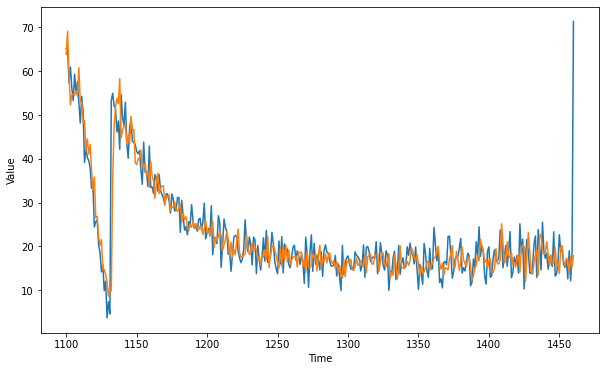

In [33]:
def generate_forecast(series = G.SERIES, split_time = G.SPLIT_TIME, window_size = G.WINDOW_SIZE):
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time+window_size][np.newaxis]))
  
  forecast = forecast[split_time-window_size:]
  results = np.array(forecast)[:,0, 0]
  return results

# Save the forecast
dnn_forecast = generate_forecast()

# Plot it
plt.figure(figsize = (10,6))
plot_series(time_valid, series_valid)
plot_series(time_valid, dnn_forecast)

In [34]:
model.save("my_model.h5")